In [ ]:
!pip install simpy

In [ ]:
import numpy as np
import pandas as pd
import pickle as pkl
import simpy
import os
import matplotlib.pyplot as plt
import sys
import simpy
from sim_func import Sim_func
import pymc as pm

## Welcome to the Queue quiz

### You are now incharge of the a queueing system in your work place. Your factory works 24/7 and creates flawless semi-conducter chips.

### Jobs are arriving with a constant rate, on average one every 12 seconds. However, the service times changes with time. We split the week into a 168 grid, where we have 7 days and 24 hours within a single day. For each cell in the grid, that is a combination of a day and an hour we have different service rate.


## Part 1:

### We first focus on a single service time of a single cell in the grid. Being more specific, Monday from 08:00 to 09:00.
### In event_log_single_ser below you have pandas dataframe with the eventlog of this specific cell.

### Your jobs is to understand what is the average service time and its distirbution using Bayesian analysis.

In [ ]:
event_log_single_ser = pkl.load(open('event_log_single_ser.pkl', 'rb'))
event_log_single_ser.head()

,customer_id,num_cust,event,time_stamp,day,hour
0,0,0,Arrival,30.105252,2,8
1,0,1,Enter_service,30.105252,2,8
2,0,0,Departure,37.798838,2,8
3,1,0,Arrival,38.750399,2,8
4,1,1,Enter_service,38.750399,2,8


## Explanation about the dataframe columns:

### 1. customer_id: the id of customer, each customer has is own id.
### 2. num_cust: the number of customers in the system (including service) prior to the event.
### 3. event: there three type of events: arrival, entering service and departing the system.
### 4. Timestamp: The total time elapased since hour 0 day 1 in seconds.
### 6. day: the day of the week from 1 to 7 where 1 is Sunday.
### 7. hour: the hour of the day 0-23, where 0 is midnight.

## Tasks:

### 1. Do Bayesian anaysis for the average service rate and its distirbution.
### 2. What did you use as the likelihood function and why?
### 3. Do  posterior predicitive anaysis to assert that the chosen likelihood distribution is valid.
### 4. According to the resulted anaysis, how certain are you about the average service prediction?

## Answers and code

### **1. Bayesian anaysis for the average service rate and its distirbution:**

Let's see how the information is defined:

In [ ]:
event_log_single_ser.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2189 entries, 0 to 2188
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   customer_id  2189 non-null   int64  
 1   num_cust     2189 non-null   int64  
 2   event        2189 non-null   object 
 3   time_stamp   2189 non-null   float64
 4   day          2189 non-null   int64  
 5   hour         2189 non-null   int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 102.7+ KB


Let's see how many unique customers there are:

In [ ]:
event_log_single_ser.groupby('customer_id').sum().shape[0]

732

We will create the service rate by the 'Departure' time minus the 'Enter_service':

In [ ]:
# Extract service times
enter_service_times = event_log_single_ser[event_log_single_ser['event'] == 'Enter_service'].set_index('customer_id')['time_stamp']
departure_times = event_log_single_ser[event_log_single_ser['event'] == 'Departure'].set_index('customer_id')['time_stamp']

# Calculate service times
service_rate = departure_times - enter_service_times
service_rate = service_rate.dropna()

service_rate

customer_id
0       7.693586
1      10.833411
2       2.347220
3       1.187283
4      16.139319
         ...    
723     2.962984
724     8.557054
725     4.835950
726    19.210130
727     5.067164
Name: time_stamp, Length: 728, dtype: float64

**Average service rate and its distirbution:**

In [ ]:
service_rate.mean()

10.189650379419726

Text(0.5, 0, 'service rate')

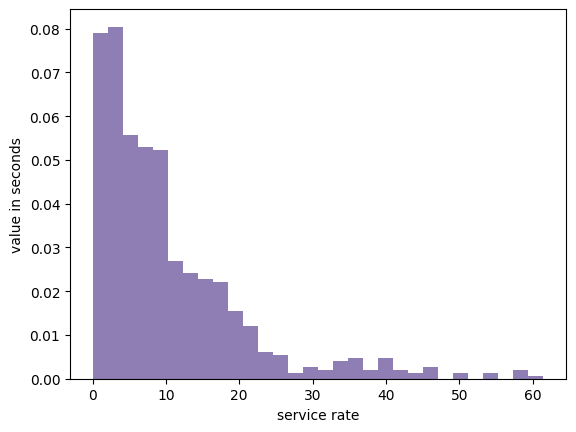

In [ ]:
plt.hist(service_rate, histtype='stepfilled', bins=30, alpha=0.85,
         label="service rate in seconds", color="#7A68A6", density=True)
plt.ylabel("value in seconds")
plt.xlabel("service rate")

Looks like an exponential distribution and since it is about time it also makes sense that this is what we will get

**Bayesian anaysis:**

In [ ]:
with pm.Model() as service_rate_model:

    # Priors for unknown model parameters
    sigma = 1.0/service_rate.mean()
    lamda = pm.HalfNormal('lamda', sigma=sigma)

    # Likelihood (sampling distribution) of observations
    service_rate_obs = pm.Exponential('service_rate_obs', lam=lamda, observed=service_rate)

    # Sample from the posterior
    trace = pm.sample(5000, tune=1000)

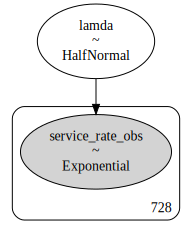

In [ ]:
from pymc import model_to_graphviz
model_to_graphviz(service_rate_model)

array([[<Axes: title={'center': 'lamda'}>,
        <Axes: title={'center': 'lamda'}>]], dtype=object)

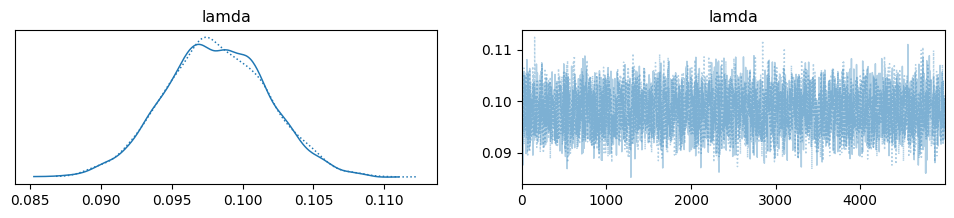

In [ ]:
import arviz as az
az.plot_trace(trace)

<Axes: title={'center': 'lamda'}>

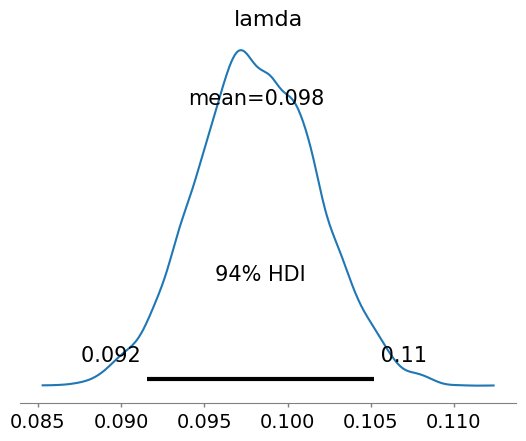

In [ ]:
az.plot_posterior(trace)

In [ ]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lamda,0.098,0.004,0.092,0.105,0.0,0.0,4030.0,7105.0,1.0


### **Answer to section 2:**

I used an exponential distribution as the likelihood function because first of all it is service time times and also when I made a histogram for the service times it looked like a type of exponential distribution.

### **3. posterior predicitive anaysis to assert that the chosen likelihood distribution is valid:**

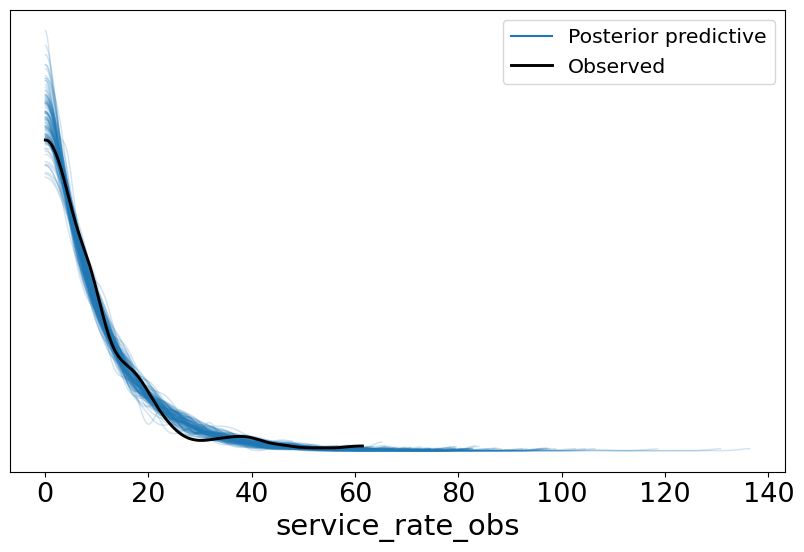

In [ ]:
RANDOM_SEED = 58
rng = np.random.default_rng(RANDOM_SEED)

# Posterior predictive checks
with service_rate_model:
    ppc = pm.sample_posterior_predictive(trace, extend_inferencedata=True, random_seed=rng)

ax = az.plot_ppc(ppc, num_pp_samples=100, figsize=(10, 6), mean=False)

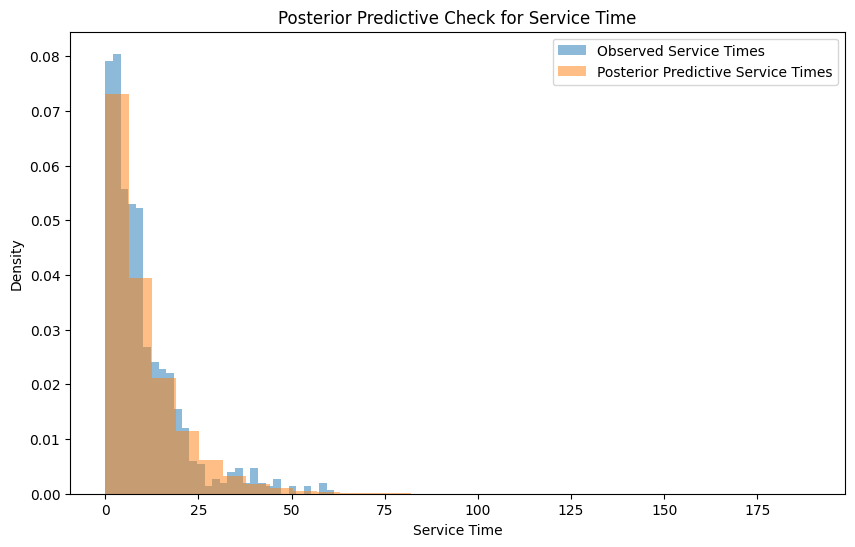

In [ ]:
# Extract and reshape posterior predictive samples
posterior_predictive_service_times = ppc['posterior_predictive']['service_rate_obs'].values.flatten()

# Compare the distributions
observed_service_times = service_rate.values

plt.figure(figsize=(10, 6))
plt.hist(observed_service_times, bins=30, alpha=0.5, label='Observed Service Times', density=True)
plt.hist(posterior_predictive_service_times, bins=30, alpha=0.5, label='Posterior Predictive Service Times', density=True)
plt.legend(loc='best')
plt.xlabel('Service Time')
plt.ylabel('Density')
plt.title('Posterior Predictive Check for Service Time')
plt.show()

### **4. According to the resulted anaysis:**

According to the analysis of the results, I wouldn't say that I am completely sure, but I am in the right direction.

The sanity check plot_trace comes out good, the two chains converge plus or minus to the same result and there does not seem to be any correlation between the samples.
However, in the sanity check sample_posterior_predictive there is some small escape of the observations between the number of samples 20-40 which is not very clear to me why it reads and therefore there is no completely normal convergence with posterior predictive.
In addition, when comparing the distributions of the posterior predictive and the observations, you do not get full coverage of the posterior predictive on the observations and this can cause us to miss important information.
In conclusion, I would not say that there is an unusual incompatibility here that cannot be worked with, but it is possible to further improve the model in order to have an even better match.

## Part 2:

### We next turn to the next part where we wish to map the average service time at each time cell.

### Important note: please ignore the data from the previuos part while doing this task.

### The data is under df_tot as given below. In the dataset we have missing parts, some cells in the grid are missing. Your job is to fill the grid.

In [25]:
df_tot = pkl.load(open('df_tot.pkl', 'rb'))
df_tot.head(5)

,Unnamed: 0,index,customer_id,num_cust,event,time_stamp,day,hour
0,0,981,327,0,Arrival,3608.653189,1,1
1,1,982,327,1,Enter_service,3608.653189,1,1
2,2,983,327,0,Departure,3609.497913,1,1
3,3,984,328,0,Arrival,3609.790566,1,1
4,4,985,328,1,Enter_service,3609.790566,1,1


## Tasks:

### 1. Extract the mean service times (taking the average time is sufficient, no need  for extra bayesian analysis) per each cell you do have data.
### 2. Use two regression methods for completing the average service time for the rest of the grid.
### 3. Plot on a 3D plot which contains the data, and the surface of the two regression methods.
### 4. What is the probability that the service time of chip, between 16:00 to 18:00, on Shabbat, will be between 6 to 7 seconds?
### 5. Please give full specification of the Gauusian distribution of the service time on Sunday between 14:00 to 15:00 and Sunday between 16:00 to 17:00.
### 6. What is the correlation between the service times at Sunday between 14:00 to 15:00 and Sunday between 16:00 to 17:00?
### What is the correlation between the service times at Sunday between 14:00 to 15:00 and Sunday between 20:00 to 21:00?
### Which correlation value is larger? does this result make sense?


### **Answers to part 2:**

**1. mean service times per each cell we do have data:**

In [26]:
# Calculate service times
enter_service = df_tot[df_tot['event'] == 'Enter_service'].set_index('customer_id')['time_stamp']
departure = df_tot[df_tot['event'] == 'Departure'].set_index('customer_id')['time_stamp']

service_times = departure - enter_service

# Group by day and hour, calculate mean service time
mean_service_times = service_times.groupby([df_tot['day'], df_tot['hour']]).mean()

# Create a DataFrame with all possible day-hour combinations in the grid
days = range(1, 8) # days range from 1 to 7
hours = range(0, 24) # hours range from 0 to 23
day_hour_combinations = [(day, hour) for day in days for hour in hours]

# Convert to DataFrame
mean_service_times_df = pd.DataFrame(index=pd.MultiIndex.from_tuples(day_hour_combinations, names=['day', 'hour']))
mean_service_times_df['mean_service_time'] = mean_service_times

# Display the resulting DataFrame
mean_service_times_df.head()

mean_service_time
day hour                   
1   0                   NaN
    1              1.293141
    2                   NaN
    3              1.893939
    4              2.982484

In [27]:
mean_service_times_df['mean_service_time'].mean()

3.654658933222642

In [28]:
import plotly.graph_objects as go
import numpy as np
import pandas as pd

# Reset index to access day and hour as columns
mean_service_times_df = mean_service_times_df.reset_index()

# Extract data for plotting
days = mean_service_times_df['day']
hours = mean_service_times_df['hour']
mean_service_times = mean_service_times_df['mean_service_time']

# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=days,
    y=hours,
    z=mean_service_times,
    mode='markers',
    marker=dict(
        size=5,
        color=mean_service_times,  # Set color to the mean service times
        colorscale='Viridis',  # Choose a colorscale
        opacity=0.8
    )
)])

# Set labels for axes
fig.update_layout(
    scene=dict(
        xaxis_title='Day',
        yaxis_title='Hour',
        zaxis_title='Mean Service Time'
    ),
    title='Interactive 3D Scatter Plot of Mean Service Times'
)

# Show the plot
fig.show()


**2. Using two regression methods for completing the average service time for the rest of the grid:**

**Division into training and test** (when there is no Y test). <br>
Training - the full cells. <br>
Test - the empty cells.

In [29]:
import pandas as pd

# Calculate service times
df_tot = df_tot.copy()

# Create a dictionary to store service times for each customer
service_times = {}

# Iterate over each row in the DataFrame
for _, row in df_tot.iterrows():
    customer_id = row['customer_id']
    event = row['event']
    time_stamp = row['time_stamp']

    if event == 'Enter_service':
        if customer_id not in service_times:
            service_times[customer_id] = {}
        service_times[customer_id]['enter_service'] = time_stamp
    elif event == 'Departure':
        if customer_id in service_times:
            service_times[customer_id]['departure'] = time_stamp

# Calculate service times and add them to the DataFrame
service_times_list = []
for customer_id, times in service_times.items():
    if 'enter_service' in times and 'departure' in times:
        service_time = times['departure'] - times['enter_service']
        service_times_list.append({
            'customer_id': customer_id,
            'service_time': service_time,
            'day': df_tot[df_tot['customer_id'] == customer_id]['day'].values[0],
            'hour': df_tot[df_tot['customer_id'] == customer_id]['hour'].values[0]
        })

service_times_df = pd.DataFrame(service_times_list)

# Aggregate service times by day and hour
mean_service_times_df = service_times_df.groupby(['day', 'hour'])['service_time'].mean().reset_index()

# Identify empty and filled cells
days = range(1, 8)  # days range from 1 to 7
hours = range(0, 24)  # hours range from 0 to 23
day_hour_combinations = pd.DataFrame([(day, hour) for day in days for hour in hours], columns=['day', 'hour'])

# Merge to find empty cells
merged_df = pd.merge(day_hour_combinations, mean_service_times_df, on=['day', 'hour'], how='left')

# Identify empty and filled cells
empty_cells = merged_df[merged_df['service_time'].isna()]
filled_cells = merged_df[~merged_df['service_time'].isna()]

# Prepare training and test sets
X_train = filled_cells[['day', 'hour']]
y_train = filled_cells['service_time']
X_test = empty_cells[['day', 'hour']]

print("Training Set (Filled Cells):")
print(X_train.head())
print(y_train.head())

print("Test Set (Empty Cells):")
print(X_test.head())

Training Set (Filled Cells):
    day  hour
1     1     1
3     1     3
4     1     4
7     1     7
10    1    10
1     1.293141
3     1.729359
4     2.063790
7     2.982484
10    5.594943
Name: service_time, dtype: float64
Test Set (Empty Cells):
   day  hour
0    1     0
2    1     2
5    1     5
6    1     6
8    1     8


**linear regression:**

In [30]:
# Standardize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

with pm.Model() as linear_model:
    # Priors for unknown model parameters
    β = pm.Normal('β', mu=0, sigma=50, shape=2)
    σ = pm.HalfNormal('σ', sigma=10)

    # Linear function
    μ = β[0] + β[1] * X_train_scaled[:, 1]

    # Likelihood (sampling distribution) of observations
    y_obs = pm.Normal('y_obs', mu=μ, sigma=σ, observed=y_train)

    # Sample from the posterior
    trace_linear = pm.sample(2000, tune=1000, chains=2, cores=1)

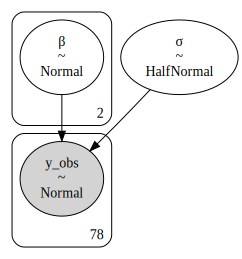

In [31]:
pm.model_to_graphviz(linear_model)

In [32]:
# Posterior predictive check
with linear_model:
    linear_pred = pm.sample_posterior_predictive(trace_linear, var_names=['β'])

In [33]:
# Extract the predictions
β_samples = linear_pred.posterior_predictive['β'].values
pred_mean_linear = np.mean(β_samples[:, 0].reshape(-1, 1) + β_samples[:, 1].reshape(-1, 1) * X_test_scaled[:, 1], axis=0)

In [34]:
# Fill the empty cells with the Linear Regression predictions
empty_cells.loc[:, 'service_time'] = pred_mean_linear

# Combine filled and empty cells
filled_grid_linear = pd.concat([filled_cells, empty_cells], ignore_index=True)
filled_grid_linear.head()

,day,hour,service_time
0,1,1,1.293141
1,1,3,1.729359
2,1,4,2.063790
3,1,7,2.982484
4,1,10,5.594943


**Gaussian process (GP)**

According to the three-dimensional graph we made in part 2, section 1, it seems that the information can have certain fluctuations, so we chose the Matern32 kernel.

In [35]:
# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = np.asarray(X_train_scaled)
y_train = np.asarray(y_train)
X_test_scaled = scaler.transform(X_test)
X_test_scaled = np.asarray(X_test_scaled)

In [36]:
with pm.Model() as gp_model:

    ## Defining the priors
    l = pm.HalfCauchy("l", beta=3, shape=(2,))
    sf2 = pm.HalfCauchy("sf2", beta=3)

    ## 6. Defining the kernel
    kenral_option = 2 # The information can have certain fluctuations
    # option 1: expquad
    if kenral_option == 1:
      K = pm.gp.cov.ExpQuad(2, l) * sf2**2
    elif kenral_option == 2:
      # option 2: Matern32
      K = pm.gp.cov.Matern32(2, l) * sf2**2
    elif kenral_option == 3:
      # option 3: Matern 52
      K = pm.gp.cov.Matern52(2, l) * sf2**2

    # 5. Mean functions
    mean_func = pm.gp.mean.Linear(coeffs=[1, 1])

    ## 4. Defining the GP process
    gp_priors = pm.gp.Marginal(mean_func=mean_func, cov_func=K)

    ## 3. Prior of the noise
    sigma = pm.HalfCauchy('sigma', beta=5)

    ## 2. Defining the likelihood
    y_obs = gp_priors.marginal_likelihood('y_obs', X=X_train_scaled, y=y_train, noise=sigma)

    ## 1. sampling mcmc
    trace_gp = pm.sample(1000, tune=1000, chains=2, cores=1)

/usr/local/lib/python3.10/dist-packages/pymc/gp/gp.py:56: FutureWarning:

The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.



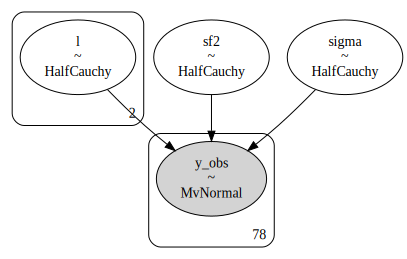

In [37]:
pm.model_to_graphviz(gp_model)

In [38]:
# Posterior predictive check
with gp_model:
    f_pred = gp_priors.conditional('f_pred', X_test_scaled)
    pred_samples = pm.sample_posterior_predictive(trace_gp, var_names=['f_pred'])

In [39]:
# Extract the predictions
pred_mean_gp = np.mean(pred_samples.posterior_predictive['f_pred'], axis=(0, 1))

In [40]:
# Fill the empty cells with the GP predictions
empty_cells.loc[:, 'service_time'] = pred_mean_gp

# Combine filled and empty cells
filled_grid_gp = pd.concat([filled_cells, empty_cells], ignore_index=True)

filled_grid_gp.tail()

,day,hour,service_time
163,7,14,7.979653
164,7,15,7.466538
165,7,16,6.427178
166,7,17,5.173373
167,7,20,2.440775


**3. A 3D plot which contains the data, and the surface of the two regression methods:**

In [41]:
import numpy as np
import plotly.graph_objects as go

# Define the correct column name
service_time_col = 'service_time'

# Extract the service time column from the DataFrames
filled_grid_linear_np = filled_grid_linear[service_time_col].to_numpy()
filled_grid_gp_np = filled_grid_gp[service_time_col].to_numpy()

print("filled_grid_linear_np shape before reshape:", filled_grid_linear_np.shape)
print("filled_grid_gp_np shape before reshape:", filled_grid_gp_np.shape)

# Create a mesh grid for the surface plots
x = np.arange(mean_service_times_df['hour'].min(), mean_service_times_df['hour'].max() + 1, 1)
y = np.arange(mean_service_times_df['day'].min(), mean_service_times_df['day'].max() + 1, 1)
X, Y = np.meshgrid(x, y)

# Flatten the mesh grid to match the data for plotting
x_flat = X.flatten()
y_flat = Y.flatten()

# Ensure the filled grids have the correct size before reshaping
expected_size = X.size
print("Expected size:", expected_size)

if filled_grid_linear_np.size == expected_size:
    filled_grid_linear_np = filled_grid_linear_np.reshape(Y.shape)
else:
    print("filled_grid_linear size does not match the expected size.")

if filled_grid_gp_np.size == expected_size:
    filled_grid_gp_np = filled_grid_gp_np.reshape(Y.shape)
else:
    print("filled_grid_gp size does not match the expected size.")

# Create a 3D scatter plot for the actual data points
scatter_data = go.Scatter3d(
    x=mean_service_times_df['hour'],
    y=mean_service_times_df['day'],
    z=mean_service_times_df['service_time'],
    mode='markers',
    marker=dict(
        size=5,
        color=mean_service_times_df['service_time'],
        colorscale='Viridis',
        opacity=0.8
    ),
    name='Data Points'
)

# Create 3D surface plot for Linear Regression
if filled_grid_linear_np.size == expected_size:
    surface_linear = go.Surface(
        x=X,
        y=Y,
        z=filled_grid_linear_np,
        colorscale='Viridis',
        opacity=0.7,
        name='Linear Regression Surface'
    )
else:
    surface_linear = None

# Create 3D surface plot for GP Regression
if filled_grid_gp_np.size == expected_size:
    surface_gp = go.Surface(
        x=X,
        y=Y,
        z=filled_grid_gp_np,
        colorscale='Plasma',
        opacity=0.7,
        name='GP Regression Surface'
    )
else:
    surface_gp = None

# Combine the plots
fig = go.Figure(data=[scatter_data])

if surface_linear is not None:
    fig.add_trace(surface_linear)

if surface_gp is not None:
    fig.add_trace(surface_gp)

# Set labels for axes
fig.update_layout(
    scene=dict(
        xaxis_title='Hour',
        yaxis_title='Day',
        zaxis_title='Service Time',
        aspectmode='manual',
        aspectratio=dict(x=1, y=1, z=1)
    ),
    title='Service Time Prediction',
    width=700,
    height=700
)

# Show the plot
fig.show()


filled_grid_linear_np shape before reshape: (168,)
filled_grid_gp_np shape before reshape: (168,)
Expected size: 168


Unsurprisingly the Gaussian process looks better.

**4. The probability that the service time of chip, between 16:00 to 18:00, on Shabbat, will be between 6 to 7 seconds:**

In [42]:
# Filter for the time between 16:00 and 18:00 on Shabbat
# Adjust 'day' value if necessary for Shabbat (day=7 represents Shabbat)
filtered_df = filled_grid_gp[(filled_grid_gp['hour'] >= 16) & (filled_grid_gp['hour'] <= 18) & (filled_grid_gp['day'] == 7)]

# Calculate the probability of service time being between 6 and 7 seconds
lower_bound = 6
upper_bound = 7

# Find the rows where service_time is between 6 and 7 seconds
within_range = (filtered_df['service_time'] >= lower_bound) & (filtered_df['service_time'] <= upper_bound)

# Compute the probability
probability_within_range = np.mean(within_range)

# Print the result
print(f'Probability that the service time is between {lower_bound} and {upper_bound} seconds between 16:00 and 18:00 on Shabbat: {probability_within_range}')

Probability that the service time is between 6 and 7 seconds between 16:00 and 18:00 on Shabbat: 0.3333333333333333


**5. Full specification of the Gauusian distribution of the service time on Sunday between 14:00 to 15:00 and Sunday between 16:00 to 17:00:**


In [43]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Extract relevant rows from filled_grid_gp for Sunday (day=1) and hours 14:00 to 15:00 and 16:00 to 17:00
sunday_data = filled_grid_gp[(filled_grid_gp['day'] == 1) & (filled_grid_gp['hour'].isin([14, 16]))]
sunday_data = sunday_data.sort_values(by=['hour'])

# Extract the service times, hours, and days
service_times = sunday_data['service_time'].values
hours = sunday_data['hour'].values
days = sunday_data['day'].values

# Combine hours and days into a single array for GP input
X = np.column_stack([days, hours])

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [44]:
# Fit the Gaussian Process model
with pm.Model() as gp_model:

    # Define the priors
    l = pm.HalfCauchy("l", beta=3, shape=(2,))
    sf2 = pm.HalfCauchy("sf2", beta=3)

    # Define the kernel
    kernel_option = 2
    if kernel_option == 1:
        K = pm.gp.cov.ExpQuad(2, l) * sf2**2
    elif kernel_option == 2:
        K = pm.gp.cov.Matern32(2, l) * sf2**2
    elif kernel_option == 3:
        K = pm.gp.cov.Matern52(2, l) * sf2**2

    # Define the mean function
    mean_func = pm.gp.mean.Linear(coeffs=[1, 1])

    # Define the GP process
    gp_priors = pm.gp.Marginal(mean_func=mean_func, cov_func=K)

    # Define the noise prior
    sigma = pm.HalfCauchy('sigma', beta=5)

    # Define the likelihood
    y_obs = gp_priors.marginal_likelihood('y_obs', X=X_scaled, y=service_times, noise=sigma)

    # Sample from the posterior
    trace_gp = pm.sample(1000, tune=1000, chains=2, cores=1, return_inferencedata=True)

/usr/local/lib/python3.10/dist-packages/pymc/gp/gp.py:56: FutureWarning:

The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.



In [45]:
# Define the time points we are interested in (hours 14, 16) for Sunday (day=1)
test_hours = np.array([14, 16])
test_days = np.array([1, 1])  # Sundays

# Combine test hours and days into a single array
X_test = np.column_stack([test_days, test_hours])

# Standardize the test features using the same scaler
X_test_scaled = scaler.transform(X_test)

# Predict the mean and covariance using the GP model
with gp_model:
    mu, cov = gp_priors.predict(X_test_scaled, point=pm.find_MAP())

# Print the results
print("Mu vector:", mu)
print("Covariance Matrix:", cov)


Mu vector: [-0.99999366  1.00000405]
Covariance Matrix: [[2.86277685e-05 0.00000000e+00]
 [0.00000000e+00 2.86277685e-05]]


**6. Which correlation value is larger?** <br>
The correlation between the service times at Sunday between 14:00 to 15:00 and Sunday between 16:00 to 17:00 **or** the correlation between the service times at Sunday between 14:00 to 15:00 and Sunday between 20:00 to 21:00. <br>
**Does this result make sense?**

In [46]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Extract relevant rows from filled_grid_gp for Sunday (day=1) and hours 14:00 to 15:00, 16:00 to 17:00, and 20:00 to 21:00
sunday_data = filled_grid_gp[(filled_grid_gp['day'] == 1) & (filled_grid_gp['hour'].isin([14, 16, 20]))]
sunday_data = sunday_data.sort_values(by=['hour'])

# Extract the service times, hours, and days
service_times = sunday_data['service_time'].values
hours = sunday_data['hour'].values
days = sunday_data['day'].values

# Combine hours and days into a single array for GP input
X = np.column_stack([days, hours])

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit the Gaussian Process model
with pm.Model() as gp_model:

    # Define the priors
    l = pm.HalfCauchy("l", beta=3, shape=(2,))
    sf2 = pm.HalfCauchy("sf2", beta=3)

    # Define the kernel
    kernel_option = 2
    if kernel_option == 1:
        K = pm.gp.cov.ExpQuad(2, l) * sf2**2
    elif kernel_option == 2:
        K = pm.gp.cov.Matern32(2, l) * sf2**2
    elif kernel_option == 3:
        K = pm.gp.cov.Matern52(2, l) * sf2**2

    # Define the mean function
    mean_func = pm.gp.mean.Linear(coeffs=[1, 1])

    # Define the GP process
    gp_priors = pm.gp.Marginal(mean_func=mean_func, cov_func=K)

    # Define the noise prior
    sigma = pm.HalfCauchy('sigma', beta=5)

    # Define the likelihood
    y_obs = gp_priors.marginal_likelihood('y_obs', X=X_scaled, y=service_times, noise=sigma)

    # Sample from the posterior
    trace_gp = pm.sample(1000, tune=1000, chains=2, cores=1, return_inferencedata=False)

# Define the time points we are interested in
test_hours = np.array([14, 16, 20])
test_days = np.array([1, 1, 1])  # Sundays

# Combine test hours and days into a single array
X_test = np.column_stack([test_days, test_hours])

# Standardize the test features using the same scaler
X_test_scaled = scaler.transform(X_test)


/usr/local/lib/python3.10/dist-packages/pymc/gp/gp.py:56: FutureWarning:

The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.



In [47]:
# Predict the mean and covariance using the GP model
with gp_model:
    mu, cov = gp_priors.predict(X_test_scaled, point=pm.find_MAP())

# Calculate correlations
corr_14_16 = cov[0, 1] / (np.sqrt(cov[0, 0] * cov[1, 1]))
corr_14_20 = cov[0, 2] / (np.sqrt(cov[0, 0] * cov[2, 2]))

# Print the results
print("Correlation between service times at Sunday 14:00 to 15:00 and Sunday 16:00 to 17:00:", corr_14_16)
print("Correlation between service times at Sunday 14:00 to 15:00 and Sunday 20:00 to 21:00:", corr_14_20)

if corr_14_16 > corr_14_20:
    print("The correlation between service times at Sunday 14:00 to 15:00 and Sunday 16:00 to 17:00 is larger.")
else:
    print("The correlation between service times at Sunday 14:00 to 15:00 and Sunday 20:00 to 21:00 is larger.")


Correlation between service times at Sunday 14:00 to 15:00 and Sunday 16:00 to 17:00: 6.874862929468016e-07
Correlation between service times at Sunday 14:00 to 15:00 and Sunday 20:00 to 21:00: -1.3029787799053793e-07
The correlation between service times at Sunday 14:00 to 15:00 and Sunday 16:00 to 17:00 is larger.


It makes sense that the correlation between two consecutive hours is higher than two hours between which there is an interval, when it is a plant that provides a service. <br>
It can be thought of like a store where people arrive in "waves" and therefore when there is no time interval the correlation is greater.

## Task 3:

### For cross validation of the previuos task we wish to see how accurate our predictions.

### We use your prediction to estimate the waiting times at each points via simulation. The better the estimation made in you GP regressior the more accurate the simulations results.

### In this part we compare the average waiting time at each cell with the true average waiting times. The true values are loaded below into 'true_results'.


In [49]:
true_results = pkl.load(open('true_results.pkl', 'rb'))
true_results.shape

(167,)

### In true_results you have a numpy array with 167 values. The first value is the  average number of customers in the system at the end of the hour 0 day 1, the second is hour 1 day 1, and so on. This is an averge of 200 simulation runs. Note that the grid contains 168 values but here we have only 167. This means, we do not test for 23:00-0:00 at the day 7 (from technincal reasons).

### In order to compute your waiting time predictions insert your predicitons into Sim_func below. Then, the line of code below extracts the average waiting time predictions into the variable  'preds_results'.

### At this point you have two vectors of size (167,),  one represents the true average waiting times and the other represent your predicitons.

### The first value represents the average waiting time at Sunday between 0:00-01:00. The 50th cell represent the average waiting time at Tuesday between 01:00 to 02:00.

## Tasks

### 1. Compute the average waiting times using the function Sim_func. Compare your results between your predictions and the ground truth using MSE.

### 2. Plot the average waiting as a function of time of the week. That is, y-axis is the average waiting time and the X-axis is the hour of the week. Following the exmaple from above Tuesday between 01:00 to 02:00 is the 50th hour.


In [50]:
# ## Insert your predictions her

# df_  = Sim_func(YOUR_PREDICTION)
# ## Converting the simulation results into a numpy array from a PD dataframe.
# preds_results = np.array(df_.iloc[:,2:]).mean(axis = 1)

### **Answers to part 3:**

**1. Computing the average waiting times using the function Sim_func, and Comparing my results between your predictions and the ground truth using MSE:**

We will repeat the distribution of the information and the model.

In [51]:
import pandas as pd

# Calculate service times
df_tot = df_tot.copy()

# Create a dictionary to store service times for each customer
service_times = {}

# Iterate over each row in the DataFrame
for _, row in df_tot.iterrows():
    customer_id = row['customer_id']
    event = row['event']
    time_stamp = row['time_stamp']

    if event == 'Enter_service':
        if customer_id not in service_times:
            service_times[customer_id] = {}
        service_times[customer_id]['enter_service'] = time_stamp
    elif event == 'Departure':
        if customer_id in service_times:
            service_times[customer_id]['departure'] = time_stamp

# Calculate service times and add them to the DataFrame
service_times_list = []
for customer_id, times in service_times.items():
    if 'enter_service' in times and 'departure' in times:
        service_time = times['departure'] - times['enter_service']
        service_times_list.append({
            'customer_id': customer_id,
            'service_time': service_time,
            'day': df_tot[df_tot['customer_id'] == customer_id]['day'].values[0],
            'hour': df_tot[df_tot['customer_id'] == customer_id]['hour'].values[0]
        })

service_times_df = pd.DataFrame(service_times_list)

# Aggregate service times by day and hour
mean_service_times_df = service_times_df.groupby(['day', 'hour'])['service_time'].mean().reset_index()

# Identify empty and filled cells
days = range(1, 8)  # days range from 1 to 7
hours = range(0, 24)  # hours range from 0 to 23
day_hour_combinations = pd.DataFrame([(day, hour) for day in days for hour in hours], columns=['day', 'hour'])

# Merge to find empty cells
merged_df = pd.merge(day_hour_combinations, mean_service_times_df, on=['day', 'hour'], how='left')

# Identify empty and filled cells
empty_cells = merged_df[merged_df['service_time'].isna()]
filled_cells = merged_df[~merged_df['service_time'].isna()]

# Prepare training and test sets
X_train = filled_cells[['day', 'hour']]
y_train = filled_cells['service_time']
X_test = empty_cells[['day', 'hour']]

print("Training Set (Filled Cells):")
print(X_train.head())
print(y_train.head())

print("Test Set (Empty Cells):")
print(X_test.head())


# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = np.asarray(X_train_scaled)
y_train = np.asarray(y_train)
X_test_scaled = scaler.transform(X_test)
X_test_scaled = np.asarray(X_test_scaled)
with pm.Model() as gp_model:

    ## Defining the priors
    l = pm.HalfCauchy("l", beta=3, shape=(2,))
    sf2 = pm.HalfCauchy("sf2", beta=3)

    ## 6. Defining the kernel
    kenral_option = 2 # The information can have certain fluctuations
    # option 1: expquad
    if kenral_option == 1:
      K = pm.gp.cov.ExpQuad(2, l) * sf2**2
    elif kenral_option == 2:
      # option 2: Matern32
      K = pm.gp.cov.Matern32(2, l) * sf2**2
    elif kenral_option == 3:
      # option 3: Matern 52
      K = pm.gp.cov.Matern52(2, l) * sf2**2

    # 5. Mean functions
    mean_func = pm.gp.mean.Linear(coeffs=[1, 1])

    ## 4. Defining the GP process
    gp_priors = pm.gp.Marginal(mean_func=mean_func, cov_func=K)

    ## 3. Prior of the noise
    sigma = pm.HalfCauchy('sigma', beta=5)

    ## 2. Defining the likelihood
    y_obs = gp_priors.marginal_likelihood('y_obs', X=X_train_scaled, y=y_train, noise=sigma)

    ## 1. sampling mcmc
    trace_gp = pm.sample(1000, tune=1000, chains=2, cores=1)

# Posterior predictive check
with gp_model:
    f_pred = gp_priors.conditional('f_pred', X_test_scaled)
    pred_samples = pm.sample_posterior_predictive(trace_gp, var_names=['f_pred'])

# Extract the predictions
pred_mean_gp = np.mean(pred_samples.posterior_predictive['f_pred'], axis=(0, 1))

# Fill the empty cells with the GP predictions
empty_cells.loc[:, 'service_time'] = pred_mean_gp

# Combine filled and empty cells
filled_grid_gp = pd.concat([filled_cells, empty_cells], ignore_index=True)

filled_grid_gp.tail()

Training Set (Filled Cells):
    day  hour
1     1     1
3     1     3
4     1     4
7     1     7
10    1    10
1     1.293141
3     1.729359
4     2.063790
7     2.982484
10    5.594943
Name: service_time, dtype: float64
Test Set (Empty Cells):
   day  hour
0    1     0
2    1     2
5    1     5
6    1     6
8    1     8


/usr/local/lib/python3.10/dist-packages/pymc/gp/gp.py:56: FutureWarning:

The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.



,day,hour,service_time
163,7,14,7.990264
164,7,15,7.478997
165,7,16,6.437767
166,7,17,5.174561
167,7,20,2.433832


We will take the predictions of our GP model including the truth data i.e. filled_grid_gp that we found in part 2 section 2, and convert the service_time column into a 7 x 24 matrix.

In [52]:
# Pivot the DataFrame to get days as rows and hours as columns
service_time_matrix = filled_grid_gp.pivot(index='day', columns='hour', values='service_time')

# Ensure the matrix has 7 rows (days) and 24 columns (hours)
# Reindex to ensure all days and hours are present
full_index = pd.Index(range(1, 8), name='day')
full_columns = pd.Index(range(0, 24), name='hour')

service_time_matrix = service_time_matrix.reindex(index=full_index, columns=full_columns)

# Convert to a NumPy array
service_time_matrix = service_time_matrix.to_numpy()

In [53]:
df_  = Sim_func(service_time_matrix)
## Converting the simulation results into a numpy array from a PD dataframe.
preds_results = np.array(df_.iloc[:,2:]).mean(axis = 1)

In [54]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(true_results, preds_results)
print(f"Mean squared error is: {mse: .4f}")

Mean squared error is:  0.1163


**2. Plot of the average waiting as a function of time of the week (following the exmaple from above Tuesday between 01:00 to 02:00 is the 50th hour):**

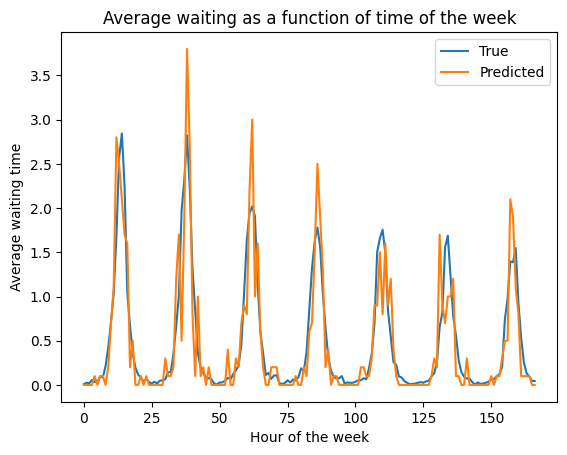

In [55]:
plt.figure()
plt.plot(np.arange(167), true_results, label = 'True')
plt.plot(np.arange(167), preds_results, label = 'Predicted')

plt.legend(loc='best')
plt.xlabel('Hour of the week')
plt.ylabel('Average waiting time')
plt.title('Average waiting as a function of time of the week')

plt.legend()
plt.show()